In [1]:
# Import modules used for the decision tree classifier & plot
# Reference code: https://www.kaggle.com/arunkumarpyramid/detection-parkinson-s-diseasefrom sklearn import preprocessing, neighbors, naive_bayes, neural_network, svm, tree
from sklearn.metrics import confusion_matrix,  roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.decomposition import PCA
from scipy import interp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
from smote import smote_binary
from performance_report import performance_report

In [3]:
# Read the csv file, dropping the unnamed id column
# Show the first 5 rows after modification for review
dataset = pd.read_csv('PD_remove_std_all_datasets.csv')
# Augment the data
# dataset = smote_multiclass(dataset, {0: 6000, 1: 6000, 2:6000, 3:6000}) #augmented dataframe
dataset.drop(['Gender'], 1, inplace=True)
dataset.head()

,Unnamed: 0,Status,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
0,0,1,0.014546,-0.000127,0.001828,0.063985,-0.181563,-0.409024,-0.076295,-0.151238,-0.220074,-1.024965
1,1,1,-0.046874,-0.000417,-0.026584,-0.072149,-0.263543,-0.594171,-0.149456,-0.189609,-0.215807,-0.867248
2,2,1,-0.016164,-0.000284,-0.016717,-0.034960,-0.316428,-0.586910,-0.192299,-0.226523,-0.252313,-1.067120
3,3,1,-0.008189,-0.000250,-0.007189,-0.042196,-0.220356,-0.056884,-0.131001,-0.158362,-0.172506,-0.740206
4,4,1,-0.040936,-0.000360,-0.029987,-0.091837,-0.312185,-0.605061,-0.201361,-0.212762,-0.195263,-0.901492


In [4]:
# Displaying the shape and datatype for each attribute
print(dataset.shape)
dataset.dtypes

(6684, 12)


Unnamed: 0            int64
Status                int64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
Jitter:PPQ5         float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
Shimmer:APQ11       float64
DFA                 float64
dtype: object

In [5]:
# Dispalying the descriptive statistics describe each attribute
dataset.describe()

,Unnamed: 0,Status,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
count,6684.000000,6684.000000,6.684000e+03,6.684000e+03,6.684000e+03,6.684000e+03,6.684000e+03,6.684000e+03,6684.000000,6.684000e+03,6.684000e+03,6.684000e+03
mean,3341.500000,0.973668,-1.594575e-18,1.575889e-17,1.355389e-17,2.365287e-17,-8.504401e-17,-6.803521e-17,0.000000,4.677421e-17,-8.504401e-17,-7.101175e-16
std,1929.648932,0.204456,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075,1.000075e+00,1.000075e+00,1.000075e+00
min,0.000000,0.000000,-3.221790e+01,-2.133261e+01,-2.485212e+01,-3.169470e+01,-2.268886e+01,-7.370397e+00,-19.637068,-2.592986e+01,-2.806578e+01,-2.319419e+01
25%,1670.750000,1.000000,-4.365040e-02,-3.739481e-04,-2.454283e-02,-6.996109e-02,-2.696799e-01,-5.869099e-01,-0.153782,-1.799356e-01,-2.248151e-01,-5.369574e-01
50%,3341.500000,1.000000,-1.972693e-02,-1.591528e-04,-1.246347e-02,-3.344573e-02,-1.292087e-01,-2.747028e-01,-0.074482,-8.663868e-02,-1.000474e-01,-4.923873e-02
75%,5012.250000,1.000000,1.318906e-02,1.732685e-04,5.102652e-03,1.989699e-02,9.642399e-02,2.081291e-01,0.063602,6.227207e-02,8.414094e-02,5.969933e-01
max,6683.000000,3.000000,3.521828e+01,6.154689e+01,4.249125e+01,3.045492e+01,4.170042e+01,6.430489e+00,40.354223,3.804147e+01,3.171104e+01,1.973819e+01


<AxesSubplot:>

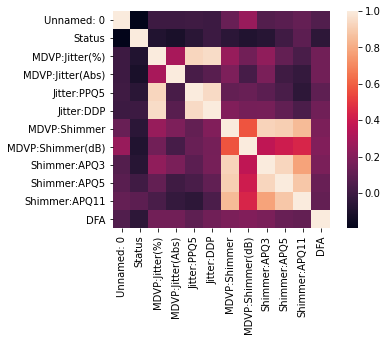

In [6]:
# Heatmap visulisation for each attribute coefficient correlation.
import seaborn as sb
corr_map=dataset.corr()
sb.heatmap(corr_map,square=True)

<AxesSubplot:>

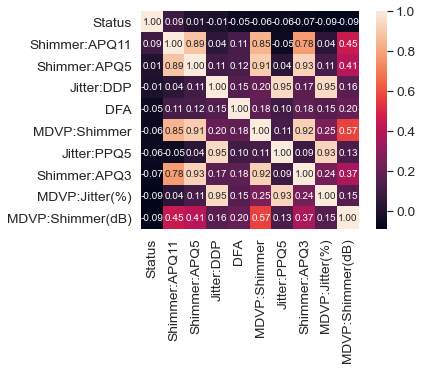

In [7]:
# Now visualise the heat map with correlation coefficient values for pair of attributes.
import matplotlib.pyplot as plt
import numpy as np

# K value means how many features required to see in heat map
k=10

# finding the columns which related to output attribute and we are arranging from top coefficient correlation value to downwards.
cols=corr_map.nlargest(k,'Status')['Status'].index

# correlation coefficient values
coff_values=np.corrcoef(dataset[cols].values.T)
sb.set(font_scale=1.25)
sb.heatmap(coff_values,cbar=True,annot=True,square=True,fmt='.2f',annot_kws={'size': 10},yticklabels=cols.values,xticklabels=cols.values)

In [8]:
# correlation coefficient values in each attributes.
correlation_values=dataset.corr()['Status']
correlation_values.abs().sort_values(ascending=False)

Status              1.000000
Unnamed: 0          0.194969
MDVP:Jitter(Abs)    0.112093
Shimmer:APQ11       0.092427
MDVP:Shimmer(dB)    0.089476
MDVP:Jitter(%)      0.088089
Shimmer:APQ3        0.069038
Jitter:PPQ5         0.062585
MDVP:Shimmer        0.059317
DFA                 0.054606
Shimmer:APQ5        0.007817
Jitter:DDP          0.005724
Name: Status, dtype: float64

In [9]:
# split the dataset into input and output attribute.

y=dataset['Status']
cols=['Status']
x=dataset.drop(cols,axis=1)

In [10]:
# Splitting the dataset into trianing and test set

train_size=0.80
test_size=0.20
seed=5

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=train_size,test_size=test_size,random_state=seed)

In [11]:
n_neighbors=5
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# keeping all models in one list
models=[]
models.append(("decision_tree",DecisionTreeClassifier()))

# Evaluating Each model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
names=[]
predictions=[]
error='accuracy'

decision_tree : 0.969890 (0.005576)


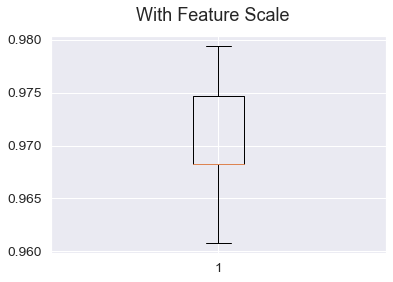

In [12]:
# Spot Checking and Comparing Algorithms With StandardScaler Scaler
from sklearn.pipeline import Pipeline
from sklearn. preprocessing import StandardScaler
pipelines=[]
pipelines.append(('scaled DecisionTree',Pipeline([('scaler',StandardScaler()),('decision',DecisionTreeClassifier())])))

# Evaluating Each model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
names=[]
predictions=[]
for name,model in models:
    fold=KFold(n_splits=10)
    result=cross_val_score(model,x_train,y_train,cv=fold,scoring=error)
    predictions.append(result)
    names.append(name)
    msg="%s : %f (%f)"%(name,result.mean(),result.std())
    print(msg)
    

# Visualizing the Model accuracy
fig=plt.figure()
fig.suptitle("With Feature Scale")
plt.boxplot(predictions)
plt.show()

In [13]:
# Decision Tree Tunning Algorithms
import numpy as np
from sklearn.model_selection import GridSearchCV
scaler=StandardScaler().fit(x_train)
rescaledx=scaler.transform(x_train)
param_grid=dict()
model=DecisionTreeClassifier()
fold=KFold(n_splits=10)
grid=GridSearchCV(estimator=model,param_grid=param_grid,scoring=error,cv=fold)
grid_result=grid.fit(rescaledx,y_train)

print("Best: %f using %s "%(grid_result.best_score_,grid_result.best_params_))

Best: 0.971198 using {} 


In [14]:
# Finalize the model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
scaler=StandardScaler().fit(x_train)
scaler_x=scaler.transform(x_train)
model.fit(scaler_x,y_train)

#Transform the validation test set data
scaledx_test=scaler.transform(x_test)
y_pred=model.predict(scaledx_test)
y_predtrain=model.predict(scaler_x)

In [15]:
# Calculate accuracy
accuracy_mean=accuracy_score(y_train,y_predtrain)
accuracy_matric=confusion_matrix(y_train,y_predtrain)
print("train set",accuracy_mean)
print("train set matrix",accuracy_matric)

accuracy_mean=accuracy_score(y_test,y_pred)
accuracy_matric=confusion_matrix(y_test,y_pred)
print("test set",accuracy_mean)
print("test set matrix",accuracy_matric)

train set 1.0
train set matrix [[ 169    0    0    0]
 [   0 5158    0    0]
 [   0    0   12    0]
 [   0    0    0    8]]
test set 0.9700822737471952
test set matrix [[  27   20    1    0]
 [  18 1263    0    0]
 [   0    0    3    0]
 [   0    1    0    4]]


/opt/anaconda3/envs/try/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/try/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/envs/try/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "/opt/anaconda3/envs/try/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 328, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/opt/anaconda3/envs/try/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these paramet

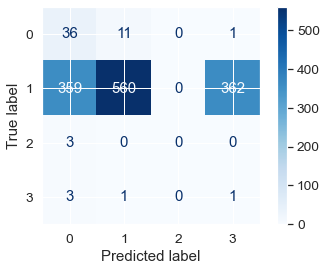

In [16]:
performance_report(model, x, y, x_test, y_test, y_pred, 'PD_remove_no_smote')
